# Demo: competing methods for CVaR estimation

This demo covers the numerical tests of different methods for estimating the CVaR of loss functions, as done in the following paper.

- Learning with risk-averse feedback under potentially heavy tails (cf. Sections 2.2 and 3). Matthew J. Holland and El Mehdi Haress. AISTATS 2021.

The contents of this demo notebook are as follows:

- <a href="#test_n">Testing performance over sample size $n$</a>
- <a href="#test_alpha">Testing performance over confidence parameter $\alpha$</a>

Assuming the user has read the README associated with this repository and done the required setup, all tests here can be easily run within this notebook. We make use of our `mml` repository just for M-estimation sub-routines.

<a id="test_n"></a>
## Testing performance over sample size $n$

In [1]:
## External modules.
import matplotlib.pyplot as plt
import numpy as np
import os

## Internal modules.
from mml.utils.mest import est_loc_fixedpt, inf_gudermann, est_scale_chi_fixedpt, chi_geman_quad
from setup_results import my_fontsize, my_ext, export_legend

In [2]:
mth_dict = {"empirical": {"simple": "Empirical",
                          "colour": "black"},
            "catoni": {"simple": "Cat-12",
                       "colour": "tab:green"},
            "mom": {"simple": "MoM",
                    "colour": "tab:orange"},
            "rtrunc": {"simple": "R-Trunc",
                       "colour": "tab:red"}}

In [3]:
## First, set task and data distribution.

task_name = "STATIC-N"

data_dist = "pareto" # set this freely.

ss = np.random.SeedSequence()
rg = np.random.default_rng(seed=ss)

def x_gen(n, data_dist):
    
    if data_dist == "lognormal":
        return rg.lognormal(mean=0.0, sigma=1.95, size=n)
    
    elif data_dist == "fnorm":
        return np.abs(rg.normal(loc=0.0, scale=3.9, size=n))
    
    elif data_dist == "pareto":
        return rg.pareto(a=2.15, size=n) * 3.8


In [4]:
## Next, set the method names.
mth_names_raw = ["empirical", "catoni", "mom", "rtrunc"]

In [5]:
## Next, set other experiment-related parameters.
num_trials = 10000
alpha = 0.05
n_verify = 100000000

## Catoni parameters and estimator prep.
_thres_Mest = 1e-03 # threshold value for M-estimator computations.
_iters_Mest = 50 # number of iterations for M-estimator computations.
_delta = 0.02 # confidence level parameter.
_s_min = 0.001 # to prevent overflow when dividing by small numbers.
est_loc = lambda X, s: est_loc_fixedpt(X=X, s=s, inf_fn=inf_gudermann,
                                       thres=_thres_Mest, iters=_iters_Mest)
est_scale = lambda X: est_scale_chi_fixedpt(X=X, chi_fn=chi_geman_quad)

## MoM parameters.
_mom_k = 1+np.ceil(3.5*np.log(1/_delta))
print("MoM k value = {}".format(_mom_k))

MoM k value = 15.0


In [6]:
## Get an accurate estimate of the true CVaR value.
x_verify = np.sort(x_gen(n=n_verify, data_dist=data_dist)) # first sample.
var = x_verify[int(np.floor((1-alpha)*n_verify))]
x_verify = x_gen(n=n_verify, data_dist=data_dist) # second sample.
cvar = np.mean(x_verify[x_verify >= var]) / alpha
del x_verify
print(cvar)

496.25993489960194


### Main test over $n$

In [7]:
n_samples = [750, 1000, 1500, 2500, 4500, 8500, 16500, 33000]
n_tocheck = 8500

aves_emp = []
aves_cat12 = []
aves_mom = []
aves_rtrunc = []

sds_emp = []
sds_cat12 = []
sds_mom = []
sds_rtrunc = []

tocheck_dict = {}

for idx_n in range(len(n_samples)):
    
    n_sample = n_samples[idx_n]
    print("Working (n = {})".format(n_sample))

    diffs_emp = []
    diffs_cat12 = []
    diffs_mom = []
    diffs_rtrunc = []
    
    for t in range(num_trials):

        x_var = x_gen(n=int(np.floor(n_sample/2)), data_dist=data_dist)
        x_est = x_gen(n=int(np.floor(n_sample/2)), data_dist=data_dist)

        idx_break = int(np.floor(n_sample/2))
        var_hat = np.sort(x_var)[int(np.floor((1-alpha)*x_var.size))]

        x_est_cond = x_est[x_est >= var_hat]

        ## Empirical.
        if x_est_cond.size < 1:
            cvar_hat_emp = np.max(x_est) / alpha
        else:
            cvar_hat_emp = np.mean(x_est_cond) / alpha
        diffs_emp += [np.abs(cvar_hat_emp-cvar)]

        ## Catoni.
        if x_est_cond.size < 2:
            cvar_hat_cat12 = np.max(x_est) / alpha
        else:
            s_est = np.sqrt(x_est.size/np.log(1/_delta))
            s_est *= est_scale(x_est_cond-x_est_cond.mean())
            s_est = np.maximum(s_est, _s_min) # ensure not too small.
            cvar_hat_cat12 = est_loc(X=x_est_cond, s=s_est).item() / alpha
        diffs_cat12 += [np.abs(cvar_hat_cat12-cvar)]
        
        ## Median-of-means.
        if x_est_cond.size < 2*_mom_k:
            if x_est_cond.size < 1:
                cvar_hat_mom = np.max(x_est) / alpha
            else:
                cvar_hat_mom = np.mean(x_est_cond) / alpha
        else:
            cvar_hat_mom = np.median([ val.mean() for val in np.array_split(x_est_cond, _mom_k) ]) / alpha
        diffs_mom += [np.abs(cvar_hat_mom-cvar)]

        ## Random truncation.
        if x_est_cond.size < 1:
            cvar_hat_rtrunc = np.max(x_est) / alpha
        else:
            u_hat = np.mean(x_est**2)
            b = np.sqrt(u_hat*(np.arange(x_est.size)+1)/np.log(1/_delta))
            b_cond = b[x_est >= var_hat]
            x_est_cond_b = x_est_cond[x_est_cond <= b_cond]
            if x_est_cond_b.size < 1:
                cvar_hat_rtrunc = 0.0
            else:
                cvar_hat_rtrunc = np.mean(x_est_cond_b) / alpha
        diffs_rtrunc += [np.abs(cvar_hat_rtrunc-cvar)]

    aves_emp += [np.mean(np.array(diffs_emp))]
    aves_cat12 += [np.mean(np.array(diffs_cat12))]
    aves_mom += [np.mean(np.array(diffs_mom))]
    aves_rtrunc += [np.mean(np.array(diffs_rtrunc))]
    sds_emp += [np.std(np.array(diffs_emp))]
    sds_cat12 += [np.std(np.array(diffs_cat12))]
    sds_mom += [np.std(np.array(diffs_mom))]
    sds_rtrunc += [np.std(np.array(diffs_rtrunc))]
    
    if n_sample == n_tocheck:
        tocheck_dict["empirical"] = np.array(diffs_emp)
        tocheck_dict["catoni"] = np.array(diffs_cat12)
        tocheck_dict["mom"] = np.array(diffs_mom)
        tocheck_dict["rtrunc"] = np.array(diffs_rtrunc)
    
    
aves_dict = {"empirical": np.array(aves_emp),
             "catoni": np.array(aves_cat12),
             "mom": np.array(aves_mom),
             "rtrunc": np.array(aves_rtrunc)}
sds_dict = {"empirical": np.array(sds_emp),
             "catoni": np.array(sds_cat12),
            "mom": np.array(sds_mom),
             "rtrunc": np.array(sds_rtrunc)}

Working (n = 750)
Working (n = 1000)
Working (n = 1500)
Working (n = 2500)
Working (n = 4500)
Working (n = 8500)
Working (n = 16500)
Working (n = 33000)


In [8]:
# Select methods for visualization.
mth_todo_idx = [0, 1, 2, 3]
mth_todo = [ mth_names_raw[m] for m in mth_todo_idx ]
print("Methods to check (raw):", mth_todo)
mth_todo_simple = [ mth_dict[mth]["simple"] for mth in mth_todo ]
print("Methods to check (simplified):", mth_todo_simple)
mth_todo_colours = [ mth_dict[mth]["colour"] for mth in mth_todo ]

Methods to check (raw): ['empirical', 'catoni', 'mom', 'rtrunc']
Methods to check (simplified): ['Empirical', 'Cat-12', 'MoM', 'R-Trunc']


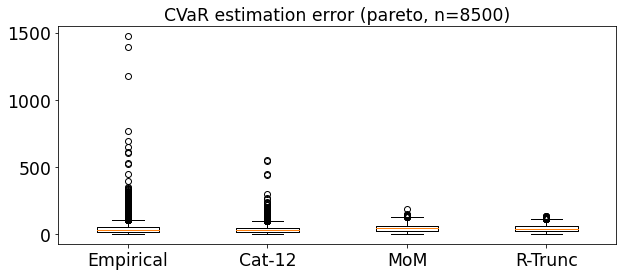

In [9]:
# Boxplot of all methods for particular "n" value.

myfig, ax = plt.subplots(1, 1, figsize=(10,4))

perf_tostack = []

perf_tostack = []
for m in range(len(mth_todo)):
    perf_tostack += [tocheck_dict[mth_todo[m]]]
    
ax.boxplot(x=np.vstack(perf_tostack).T,
           notch=False,
           labels=mth_todo_simple)
ax.tick_params(labelsize=my_fontsize)
ax.set_title("CVaR estimation error ({}, n={})".format(data_dist, n_tocheck), size=my_fontsize)

fname = os.path.join("img", "{}_box_{}.{}".format(task_name, data_dist, my_ext))
plt.savefig(fname=fname, bbox_inches="tight")

plt.show()

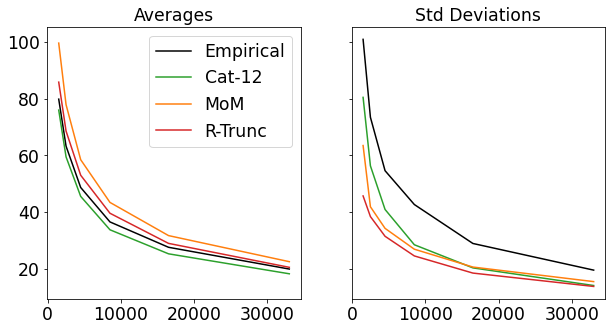

In [10]:
# Do the visualization.

myfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

for m in range(len(mth_todo_idx)):
    xvals = np.array(n_samples)[2:]
    yvals = aves_dict[mth_todo[m]][2:]
    ax1.plot(xvals, yvals, label=mth_todo_simple[m], color=mth_todo_colours[m])
    
ax1.tick_params(labelsize=my_fontsize)
ax1.legend(loc=0, ncol=1, fontsize=my_fontsize)
ax1.set_title("Averages", size=my_fontsize)

for m in range(len(mth_todo)):
    xvals = np.array(n_samples)[2:]
    yvals = sds_dict[mth_todo[m]][2:]
    ax2.plot(xvals, yvals, label=mth_todo_simple[m], color=mth_todo_colours[m])
    
ax2.tick_params(labelsize=my_fontsize)
ax2.set_title("Std Deviations", size=my_fontsize)

fname = os.path.join("img", "{}_plot_{}.{}".format(task_name, data_dist, my_ext))
plt.savefig(fname=fname, bbox_inches="tight")

plt.show()

___

<a id="test_alpha"></a>
## Testing performance over confidence parameter $\alpha$

In [1]:
## External modules.
import matplotlib.pyplot as plt
import numpy as np
import os

## Internal modules.
from mml.utils.mest import est_loc_fixedpt, inf_gudermann, est_scale_chi_fixedpt, chi_geman_quad
from setup_results import my_fontsize, my_ext, export_legend

In [2]:
mth_dict = {"empirical": {"simple": "Empirical",
                          "colour": "black"},
            "catoni": {"simple": "Cat-12",
                       "colour": "tab:green"},
            "mom": {"simple": "MoM",
                    "colour": "tab:orange"},
            "rtrunc": {"simple": "R-Trunc",
                       "colour": "tab:red"}}

In [3]:
## First, set task and data distribution.

task_name = "STATIC-A"

data_dist = "pareto" # set this freely.

ss = np.random.SeedSequence()
rg = np.random.default_rng(seed=ss)

def x_gen(n, data_dist):
    
    if data_dist == "lognormal":
        return rg.lognormal(mean=0.0, sigma=1.95, size=n)
    
    elif data_dist == "fnorm":
        return np.abs(rg.normal(loc=0.0, scale=3.9, size=n))
    
    elif data_dist == "pareto":
        return rg.pareto(a=2.15, size=n) * 3.8


In [4]:
## Next, set the method names.
mth_names_raw = ["empirical", "catoni", "mom", "rtrunc"]

In [5]:
## Next, set other experiment-related parameters.
num_trials = 10000
n_sample = 10000
n_verify = 100000000

## Catoni parameters and estimator prep.
_thres_Mest = 1e-03 # threshold value for M-estimator computations.
_iters_Mest = 50 # number of iterations for M-estimator computations.
_delta = 0.02 # confidence level parameter.
_s_min = 0.001 # to prevent overflow when dividing by small numbers.
est_loc = lambda X, s: est_loc_fixedpt(X=X, s=s, inf_fn=inf_gudermann,
                                       thres=_thres_Mest, iters=_iters_Mest)
est_scale = lambda X: est_scale_chi_fixedpt(X=X, chi_fn=chi_geman_quad)

## MoM parameters.
_mom_k = 1+np.ceil(3.5*np.log(1/_delta))
print("MoM k value = {}".format(_mom_k))


MoM k value = 15.0


### Main test over $\alpha$

In [6]:
a_values = [0.15, 0.125, 0.10, 0.075, 0.05, 0.025]
alpha_tocheck = 0.075

aves_emp = []
aves_cat12 = []
aves_mom = []
aves_rtrunc = []

sds_emp = []
sds_cat12 = []
sds_mom = []
sds_rtrunc = []

tocheck_dict = {}

for idx_a in range(len(a_values)):
    
    alpha = a_values[idx_a]
    
    ## Get an accurate estimate of the true CVaR value.
    x_verify = np.sort(x_gen(n=n_verify, data_dist=data_dist)) # first sample.
    var = x_verify[int(np.floor((1-alpha)*n_verify))]
    x_verify = x_gen(n=n_verify, data_dist=data_dist) # second sample.
    cvar = np.mean(x_verify[x_verify >= var]) / alpha
    del x_verify
    print("Alpha = {}, CVaR = {}.".format(alpha,cvar))

    diffs_emp = []
    diffs_cat12 = []
    diffs_mom = []
    diffs_rtrunc = []
    
    for t in range(num_trials):

        x_var = x_gen(n=int(np.floor(n_sample/2)), data_dist=data_dist)
        x_est = x_gen(n=int(np.floor(n_sample/2)), data_dist=data_dist)

        idx_break = int(np.floor(n_sample/2))
        var_hat = np.sort(x_var)[int(np.floor((1-alpha)*x_var.size))]

        x_est_cond = x_est[x_est >= var_hat]

        ## Empirical.
        if x_est_cond.size < 1:
            cvar_hat_emp = np.max(x_est) / alpha
        else:
            cvar_hat_emp = np.mean(x_est_cond) / alpha
        diffs_emp += [np.abs(cvar_hat_emp-cvar)]

        ## Catoni.
        if x_est_cond.size < 2:
            cvar_hat_cat12 = np.max(x_est) / alpha
        else:
            s_est = np.sqrt(x_est.size/np.log(1/_delta))
            s_est *= est_scale(x_est_cond-x_est_cond.mean())
            s_est = np.maximum(s_est, _s_min) # ensure not too small.
            cvar_hat_cat12 = est_loc(X=x_est_cond, s=s_est).item() / alpha
        diffs_cat12 += [np.abs(cvar_hat_cat12-cvar)]
        
        ## Median-of-means.
        if x_est_cond.size < 2*_mom_k:
            if x_est_cond.size < 1:
                cvar_hat_mom = np.max(x_est) / alpha
            else:
                cvar_hat_mom = np.mean(x_est_cond) / alpha
        else:
            cvar_hat_mom = np.median([ val.mean() for val in np.array_split(x_est_cond, _mom_k) ]) / alpha
        diffs_mom += [np.abs(cvar_hat_mom-cvar)]

        ## Random truncation.
        if x_est_cond.size < 1:
            cvar_hat_rtrunc = np.max(x_est) / alpha
        else:
            u_hat = np.mean(x_est**2)
            b = np.sqrt(u_hat*(np.arange(x_est.size)+1)/np.log(1/_delta))
            b_cond = b[x_est >= var_hat]
            x_est_cond_b = x_est_cond[x_est_cond <= b_cond]
            if x_est_cond_b.size < 1:
                cvar_hat_rtrunc = 0.0
            else:
                cvar_hat_rtrunc = np.mean(x_est_cond_b) / alpha
        diffs_rtrunc += [np.abs(cvar_hat_rtrunc-cvar)]

    aves_emp += [np.mean(np.array(diffs_emp))]
    aves_cat12 += [np.mean(np.array(diffs_cat12))]
    aves_mom += [np.mean(np.array(diffs_mom))]
    aves_rtrunc += [np.mean(np.array(diffs_rtrunc))]
    sds_emp += [np.std(np.array(diffs_emp))]
    sds_cat12 += [np.std(np.array(diffs_cat12))]
    sds_mom += [np.std(np.array(diffs_mom))]
    sds_rtrunc += [np.std(np.array(diffs_rtrunc))]
    
    if alpha == alpha_tocheck:
        tocheck_dict["empirical"] = np.array(diffs_emp)
        tocheck_dict["catoni"] = np.array(diffs_cat12)
        tocheck_dict["mom"] = np.array(diffs_mom)
        tocheck_dict["rtrunc"] = np.array(diffs_rtrunc)
    
    
aves_dict = {"empirical": np.array(aves_emp),
             "catoni": np.array(aves_cat12),
             "mom": np.array(aves_mom),
             "rtrunc": np.array(aves_rtrunc)}
sds_dict = {"empirical": np.array(sds_emp),
             "catoni": np.array(sds_cat12),
            "mom": np.array(sds_mom),
             "rtrunc": np.array(sds_rtrunc)}

Alpha = 0.15, CVaR = 89.09894309202892.
Alpha = 0.125, CVaR = 119.12319675751189.
Alpha = 0.1, CVaR = 169.2535955767604.
Alpha = 0.075, CVaR = 265.0088000798522.
Alpha = 0.05, CVaR = 496.3824791155511.
Alpha = 0.025, CVaR = 1429.8054267425216.


In [7]:
# Select methods for visualization.
mth_todo_idx = [0, 1, 2, 3]
mth_todo = [ mth_names_raw[m] for m in mth_todo_idx ]
print("Methods to check (raw):", mth_todo)
mth_todo_simple = [ mth_dict[mth]["simple"] for mth in mth_todo ]
print("Methods to check (simplified):", mth_todo_simple)
mth_todo_colours = [ mth_dict[mth]["colour"] for mth in mth_todo ]

Methods to check (raw): ['empirical', 'catoni', 'mom', 'rtrunc']
Methods to check (simplified): ['Empirical', 'Cat-12', 'MoM', 'R-Trunc']


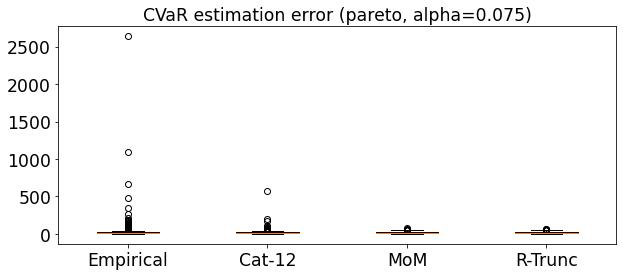

In [8]:
# Boxplot of all methods for particular "n" value.

myfig, ax = plt.subplots(1, 1, figsize=(10,4))

perf_tostack = []

perf_tostack = []
for m in range(len(mth_todo)):
    perf_tostack += [tocheck_dict[mth_todo[m]]]
    
ax.boxplot(x=np.vstack(perf_tostack).T,
           notch=False,
           labels=mth_todo_simple)
ax.tick_params(labelsize=my_fontsize)
ax.set_title("CVaR estimation error ({}, alpha={})".format(data_dist, alpha_tocheck), size=my_fontsize)

fname = os.path.join("img", "{}_box_{}.{}".format(task_name, data_dist, my_ext))
plt.savefig(fname=fname, bbox_inches="tight")

plt.show()

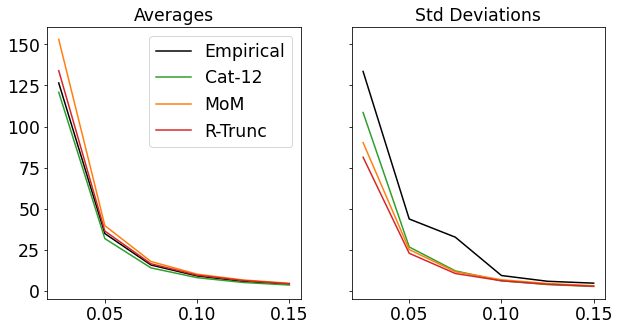

In [9]:
# Do the visualization.

myfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

for m in range(len(mth_todo_idx)):
    xvals = np.array(a_values)
    yvals = aves_dict[mth_todo[m]]
    ax1.plot(xvals, yvals, label=mth_todo_simple[m], color=mth_todo_colours[m])
    
ax1.tick_params(labelsize=my_fontsize)
ax1.legend(loc=0, ncol=1, fontsize=my_fontsize)
ax1.set_title("Averages", size=my_fontsize)

for m in range(len(mth_todo)):
    xvals = np.array(a_values)
    yvals = sds_dict[mth_todo[m]]
    ax2.plot(xvals, yvals, label=mth_todo_simple[m], color=mth_todo_colours[m])
    
ax2.tick_params(labelsize=my_fontsize)
ax2.set_title("Std Deviations", size=my_fontsize)

fname = os.path.join("img", "{}_plot_{}.{}".format(task_name, data_dist, my_ext))
plt.savefig(fname=fname, bbox_inches="tight")

plt.show()

___